# Final Project - Anthony Tobias

### 12/11/2023

### CPSC 322

# 1. Introduction

This project will be used to classify if the home team will win a game based on ranking, and season averages for scoring, field goal percentage, assists, etc. My project contains 3 different datasets which are combined for this. Since there was so much data, and my stratify functions were taking so long to run, I decided to only use data from 2016 - 2022, which is about half of the original data. My initial goal for this assignment was to have about 70% accuracy and similar recall and precision.

## Datasets

### Game Data:
This table consists of the two teams that played, the date, score of the game, box score stats (assists, rebounds, steals, shooting %, etc.) as well as a classifier (0 or 1) of whether or not the home team won the game. In order to get this done, I partitioned by season, and normalized all the data for each season. Then I partitioned by team and calculated the teams average up until that game. I did that twice in order to get home and away statistics. Then, for each game I calculated a combined statistic for the home team and the away team which took the average of their statistics. 

    Ex. (Avg Home Team Pts scored + Avg Away Team Pts allowed) / 2

### Team Names:
This table is basically exaclty the way it sounds. I mostly used this table for readability of the tables, knowing which teams were actually playing rather than just seeing Ids for the teams


### Rankings:
This table shows a date, and some basic statistics for teams up until that point in the season including Win %, wins, losses, games played etc. I used this and combined it with the game data table in order to create my final table to be used for classification


### Findings from 3 Simple Models
Throughout this first part of the project, I found that Knn is a significantly better predictor than both Naive Bayes and the Decision Tree. It averaged around 78% accuracy and very similar recall and precision from the many tests that I ran. 

### Notes:
Any function that were not created during the homeworks done in class are contained in a cell in the notebook or `helper_functions.py`

## To Run Code:

My suggestion is to select "Run All". My code does take around 55 minutes to run completely, but it is much easier than trying to run each cell individually.

In [70]:
from data_table import *
from data_util import *
from data_learn import *
from data_eval import *
from helper_functions import *
import copy

# 2. Data Analysis
This section shows I decided to load, clean and adjust my data in order to use for testing my classifiers

### Summary of Analysis

1. Get game data, remove rows with missing data and duplicates (should not be any but here for insurance), and drop unnecessary (repeated) columns
2. Partition into home and away tables and partition by season for calculations 
3. Normalize box score data
4. Partition each table by team change each row to the averages for the team up until that point of the season
5. Combine the data from each table into a single table that takes the average stats from both teams for each matchup. (this is described in more detail later in the book)
6. Union the home and away partitions into 2 tables (respectively)
7. Join both tables with home and away data
8. Combine Data with Team Name dataset and Rankings dataset

## 2.1 Load and Clean Game Data
Get the data of games, remove rows with any missing values or duplicates, and drop desired columns.

Additionally, only the games from the 2016 season or later will be used. I used this cutoff for 2 reasons:
1. In order to speed of up my classifiers
2. I feel the game of basketball has changed signficantly from the earlier years, and feel that 2016 would be a good cut point

In [71]:
game_labels = ['Date', 'Game ID', 'Status', 'Home Team ID', 'Visitor Team ID', 'Season', 
               'Team ID Home', 'PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home', 
               'Team ID Away', 'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away', 'Home Wins']
game = DataTable(game_labels)
game_temp = DataTable(game_labels)
game_temp.load('games.csv')

# only have games 2015 or later
for row in game_temp:
    if row['Season'] > 2015:
        game.append(row.values())
        
        
game = remove_missing(game, game.columns())
game.drop(['Team ID Home', 'Team ID Away', 'Status'])
game = remove_duplicates(game)

In [72]:
print(f'The number of instances in the games table is {game.row_count()}')

The number of instances in the games table is 8586


## 2.2 Partition Data by Season
Below, the original table is partitioned by season twice. One to keep track of home teams and one to keep track of away teams.

In [73]:
# partition based on season to normalize
home_data = partition(game, ['Season'])

# partition based on season to normalize
away_data = partition(game, ['Season'])

### 2.2.1 Figure 1

Below I displayed the number of games for each season. I did this to show that each should be very similar other than 2022, where there has not yet been a full season of data entered.

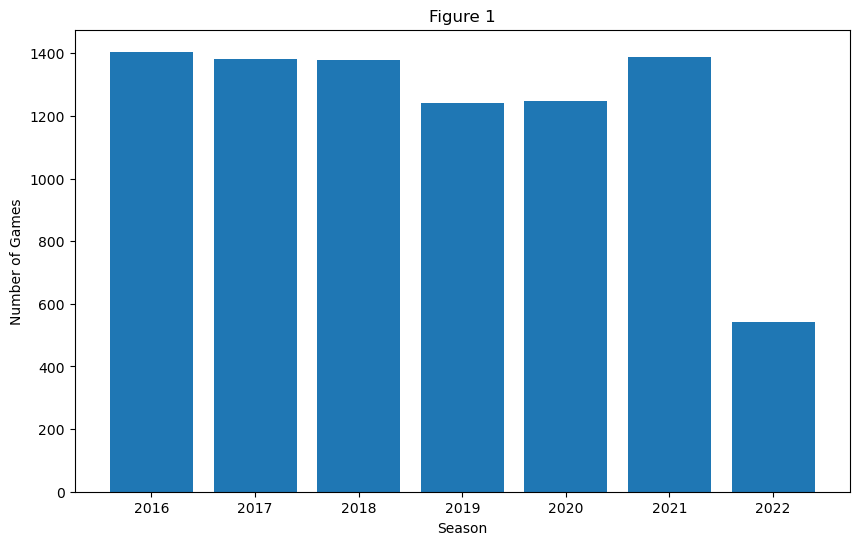

In [76]:
years = []
num_games = []

for i in range(len(home_data)):
    years.append(home_data[i][0]['Season'])
    num_games.append(home_data[i].row_count())
    
bar_chart(num_games, years, 'Season', 'Number of Games', 'Figure 1')

## 2.3 Normalize Game Data by Season
I normalized the "box score" data for each table (season), and printed out the first table (2022 season)

In [80]:
# normalize team stats by season
normalize_game_columns = ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                          'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']
for i in range(len(home_data)):
    for col in normalize_game_columns:
        home_data[i] = normalize(home_data[i], col)
        away_data[i] = normalize(away_data[i], col)

print(home_data[0])

Date          Game ID    Home Team ID    Visitor Team ID    Season    PTS Home    FG PCT Home    FT PCT Home    FG3 PCT Home    AST Home    REB Home    PTS Away    FG PCT Away    FT PCT Away    FG3 PCT Away    AST Away    REB Away    Home Wins
----------  ---------  --------------  -----------------  --------  ----------  -------------  -------------  --------------  ----------  ----------  ----------  -------------  -------------  --------------  ----------  ----------  -----------
2022-12-22   22200477      1610612740         1610612759      2022   0.653846       0.512821       0.876667        0.523452    0.392857    0.511628     0.5625       0.480243         0.735714       0.440329    0.392857     0.538462            1
2022-12-22   22200478      1610612762         1610612764      2022   0.576923       0.524217       0.92            0.664165    0.0714286   0.372093     0.484375     0.732523         0.664286       0.465021    0.285714     0.358974            1
2022-12-21   22200466   

### 2.3.1 Display Normalized PTS
Figure displays a normalized version of the box score columns as shown in the cell above. This shows that instead of having the number of each specific stat, they are now all values between 0 and 1.

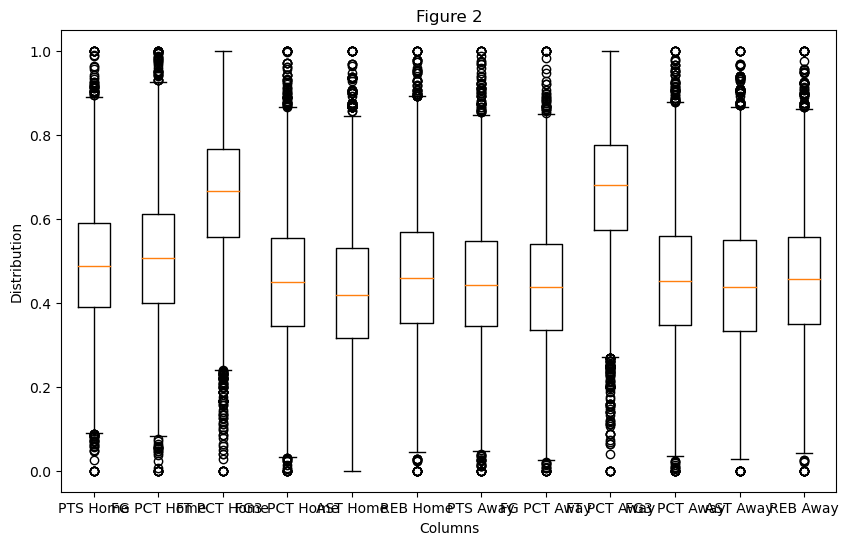

In [81]:
vals = []
for col in normalize_game_columns:
    tmp = []
    for table in home_data:
        for row in table:
            tmp.append(row[col])
    vals.append(tmp)
    
box_plot(vals, normalize_game_columns, 'Columns', 'Distribution', 'Figure 2')

## 2.4 Partition each Season by Team

I partitioned each table in my lists by team. Now I have 2 lists, the first contains normalized data for each home team for each season, while the second table is the same, but for away teams

In [82]:
season_team_home = []
season_team_away = []

for table in home_data:
    temp_game_data = partition(table, ['Home Team ID'])
    for t in temp_game_data:
        season_team_home.append(t)

for table in away_data:
    temp_game_data = partition(table, ['Visitor Team ID'])
    for t in temp_game_data:
        season_team_away.append(t)

## 2.5 Get Team Averages
Calculate averages for a team up until that point in a season for both home and away games. 

I printed the first row of the first table in each partition to show that they are normalized.
These rows should be of the same game, but have different values.

Ex. The home table shows the average points scored for home team and given up to away teams. Meanwhile the away table shows the average points scored for the away team and given up to home teams.

In [83]:
averages_home = []

for table in season_team_home:
    averages_home.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                                'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))

print(averages_home[0][0])
    

Date          Game ID    Home Team ID    Visitor Team ID    Season    PTS Home    FG PCT Home    FT PCT Home    FG3 PCT Home    AST Home    REB Home    PTS Away    FG PCT Away    FT PCT Away    FG3 PCT Away    AST Away    REB Away    Home Wins
----------  ---------  --------------  -----------------  --------  ----------  -------------  -------------  --------------  ----------  ----------  ----------  -------------  -------------  --------------  ----------  ----------  -----------
2022-12-22   22200477      1610612740         1610612759      2022    0.530627       0.535613       0.627778        0.498228    0.456349    0.449612    0.432292       0.420973       0.675635        0.464106    0.436508    0.464387            1


In [84]:
averages_away = []

for table in season_team_away:
    averages_away.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                                'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))

print(averages_away[0][0])

Date          Game ID    Home Team ID    Visitor Team ID    Season    PTS Home    FG PCT Home    FT PCT Home    FG3 PCT Home    AST Home    REB Home    PTS Away    FG PCT Away    FT PCT Away    FG3 PCT Away    AST Away    REB Away    Home Wins
----------  ---------  --------------  -----------------  --------  ----------  -------------  -------------  --------------  ----------  ----------  ----------  -------------  -------------  --------------  ----------  ----------  -----------
2022-12-22   22200477      1610612740         1610612759      2022    0.576068       0.597531       0.542778        0.544715    0.509524    0.454264    0.455208       0.450659       0.582286        0.508916    0.559524    0.499145            1


### 2.5.1 Display Averaged Box Score Data
Figure 3 shows the averaged data that is contained in each table. This should prove that there are different values compared to Figure 2.

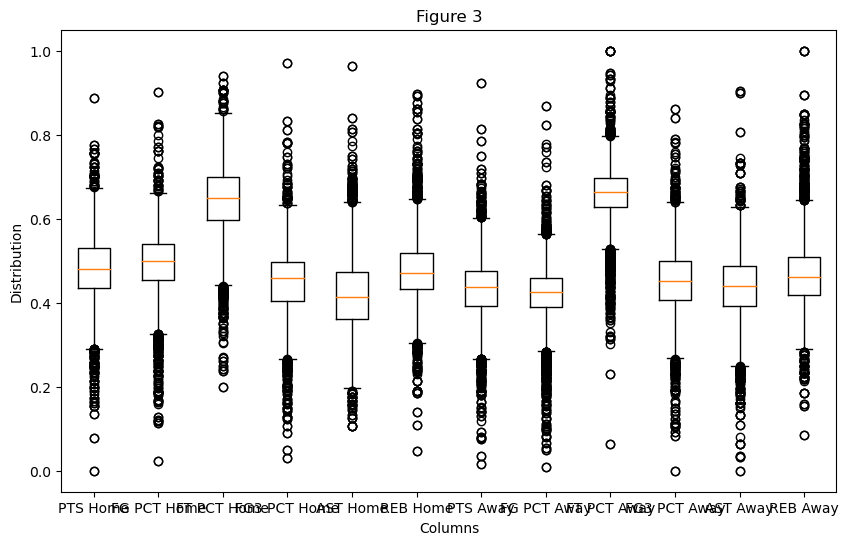

In [85]:
vals = []
for col in normalize_game_columns:
    tmp = []
    for table in averages_home:
        for row in table:
            tmp.append(row[col])
    vals.append(tmp)
    
box_plot(vals, normalize_game_columns, 'Columns', 'Distribution', 'Figure 3')

## 2.6 Union Home Data and Away Data
After this step I have 2 tables. One that contains all of the data calculated for the home teams and one for the away teams

In [86]:
home_data = union_all(averages_home)
away_data = union_all(averages_away)

## 2.7 Get Combined Averages
I averaged each of the box score stats for the away teams averages and the home teams averages. Now each row contains combined data to get the match up stats for each game

Example: `(PTS Home (from home_data) + PTS Away (from away_data)) / 2` is the new value for Home Team Points Scored

In [87]:
combined_table = calc_combined_game_stats(home_data, away_data, 
                                                        ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                                        'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away'])
    

### 2.7.1 Display Combined Averages
Once again, Figure 4 displays the combined averages for each box score stat. This figure is mostly just used to show that the values have changed in the table once again

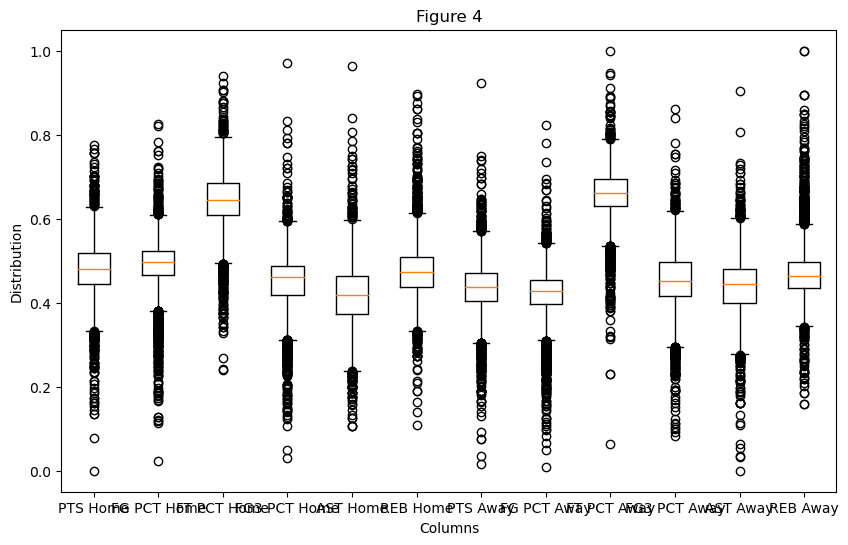

In [89]:
vals = []
for col in normalize_game_columns:
    tmp = []
    for row in combined_table:
        tmp.append(row[col])
    vals.append(tmp)
    
box_plot(vals, normalize_game_columns, 'Columns', 'Distribution', 'Figure 4')

## 2.8 Combine with other datasets

#### 2.8.1 Load Team Name Data
This data contains the name of teams, their abbreviation, city, arena, coach, etc.

In order to combine the home and away tables, I must create 2 different team tables.

These tables have the same values, but are able to combine with both home and away teams based on their column names

In [90]:
teams_labels_home = ['League ID', 'Home Team ID', 'Earliest Year', 'Latest Year', 
                'Home Team Abbreviation', 'Home Team Name', 'Founding Year', 'City',
                'Arena', 'Arena Capacity', 'Owner', 'GM', 'Coach',
                'G League Team']

home_teams = DataTable(teams_labels_home)
teams_labels_away = ['League ID', 'Visitor Team ID', 'Earliest Year', 'Latest Year', 
                'Visitor Team Abbreviation', 'Visitor Team Name', 'Founding Year', 'City',
                'Arena', 'Arena Capacity', 'Owner', 'GM', 'Coach',
                'G League Team']

visitor_teams = DataTable(teams_labels_away)
home_teams.load('teams.csv')
visitor_teams.load('teams.csv')
home_teams.drop(['League ID', 'Earliest Year', 'Latest Year', 'Founding Year', 'Arena', 'League', 'Arena Capacity', 'Owner', 'GM', 'Coach', 'G League Team'])
visitor_teams.drop(['League ID', 'Earliest Year', 'Latest Year', 'Founding Year', 'Arena', 'League', 'Arena Capacity', 'Owner', 'GM', 'Coach', 'G League Team'])

### 2.8.2 Combine with Home and Away Data
Here, I combined the home and away teams with the games they belong in for the home and away data tables.

This is used mostly for readablility of the table, and understand which team is which instead of just looking at their IDs


In [91]:
combined_table = combined_table.combine(combined_table, home_teams, ['Home Team ID'])
combined_table = combined_table.combine(combined_table, visitor_teams, ['Visitor Team ID'])
print(combined_table[0])

Date          Game ID    Home Team ID    Visitor Team ID    Season    PTS Home    FG PCT Home    FT PCT Home    FG3 PCT Home    AST Home    REB Home    PTS Away    FG PCT Away    FT PCT Away    FG3 PCT Away    AST Away    REB Away    Home Wins  Home Team Abbreviation    Home Team Name    City    Visitor Team Abbreviation    Visitor Team Name
----------  ---------  --------------  -----------------  --------  ----------  -------------  -------------  --------------  ----------  ----------  ----------  -------------  -------------  --------------  ----------  ----------  -----------  ------------------------  ----------------  ------  ---------------------------  -------------------
2022-03-01   22100927      1610612738         1610612737      2021    0.539636       0.491794       0.733673        0.481937    0.466875     0.42508    0.379597        0.39983       0.661827        0.536288    0.440697    0.461479            1  BOS                       Celtics           Boston  ATL          

### 2.8.3 Load Rankings Data
This data contains each team, season, and their ranking based on a certain date. This includes their records at home vs away, as well as total win percentage. These will be numeric and nominal columns to be used in my model

Once again, These must be split into home and away for combining.

In [92]:
ranking_labels_home = ['Home Team ID', 'League ID', 'Season ID', 'Date', 'Conference',
                  'Home Team Name', 'Home Games Played', 'Home Wins', 'Home Losses', 'Home Win PCT',
                  'Home Team Home Record', 'Home Team Away Record', 'Return To Play']
rankings_home = DataTable(ranking_labels_home)

ranking_labels_away = ['Visitor Team ID', 'League ID', 'Season ID', 'Date', 'Conference',
                  'Visitor Team Name', 'Visitor Games Played', 'Visitor Wins', 'Visitor Losses', 'Visitor Win PCT',
                  'Visitor Team Home Record', 'Visitor Team Away Record', 'Return To Play']

rankings_away = DataTable(ranking_labels_away)

rankings_home.load('ranking.csv')
rankings_home.drop(['League ID', 'Conference', 'Return To Play', 'Season ID'])
rankings_home = remove_duplicates(rankings_home)
rankings_home = remove_missing(rankings_home, rankings_home.columns())

rankings_away.load('ranking.csv')
rankings_away.drop(['League ID', 'Conference', 'Return To Play', 'Season ID'])
rankings_away = remove_duplicates(rankings_away)
rankings_away = remove_missing(rankings_away, rankings_away.columns())

### 2.8.4 Combine to Create Final Table
Combine each row in the rankings table with their respective row in the final table. This will result in the final table with all the averaged data, team names, and the rankings for both the home and away team for each game

In [13]:
combined_table = combined_table.combine(combined_table, rankings_home, ['Date', 'Home Team ID'])
final_table = combined_table.combine(combined_table, rankings_away, ['Date', 'Visitor Team ID'])
print(final_table[0])

Date          Game ID    Home Team ID    Visitor Team ID    Season    PTS Home    FG PCT Home    FT PCT Home    FG3 PCT Home    AST Home    REB Home    PTS Away    FG PCT Away    FT PCT Away    FG3 PCT Away    AST Away    REB Away    Home Wins  Home Team Abbreviation    Home Team Name    City         Visitor Team Abbreviation    Visitor Team Name      Home Games Played    Home Losses    Home Win PCT  Home Team Home Record    Home Team Away Record      Visitor Games Played    Visitor Wins    Visitor Losses    Visitor Win PCT  Visitor Team Home Record    Visitor Team Away Record
----------  ---------  --------------  -----------------  --------  ----------  -------------  -------------  --------------  ----------  ----------  ----------  -------------  -------------  --------------  ----------  ----------  -----------  ------------------------  ----------------  -----------  ---------------------------  -------------------  -------------------  -------------  --------------  ------------

# 3. Classification Results
This section shows how I generated my test sets, which classifiers I used, how I chose the parameters for my classifiers, and the results of them. 

### Summary of Classification Results
1. Get Test and Training sets
2. Select continuous columns to use for classification
2. Test KNN
3. Test Naive Bayes
4. Test Decision Tree
5. Create Tailored Classifier
6. Test Tailored Classifier
7. Results

## 3.1 Get Testing and Training Tables

In order to test each of the 3 original classifiers, I selected 1000 random instances from my data and used the rest of them for training. A season in the NBA has 1,230 games, so this is nearly a full season. The number row count of each table is displayed as well.

In [14]:
test, train = get_tables(final_table, 1000)

## 3.2 Get Continuous Columns

Below are the columns I decided to use for classification. Through testing I found that all of the continuous columns were best to use for KNN and Naive Bayes classifiers with no categorical columns. It seemed that no matter which set of categorical columns to choose, they did not work better than having none.

In [15]:
cont_cols = ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 
            'AST Home', 'REB Home', 'PTS Away', 'FG PCT Away', 'FT PCT Away', 
            'FG3 PCT Away', 'AST Away', 'REB Away', 'Home Win PCT', 'Visitor Win PCT']

    

## 3.3 Test KNN
Use the testing and training set to evaluate the knn classifier 

### 3.3.1 Run KNN and Print Matrix
I found through lots of testing that `k = 12` performed very well and decided to use this value. Below I ran knn with the continuous columns above in the singular instance test of knn. I also discovered that using these columns and no continuous columns gave my classifier the best results. The resulting confusion matrix is displayed. 

Note: This code takes about 5 minutes to complete

In [16]:
results = knn_eval(train, test, majority_vote, 12, 'Home Wins', cont_cols, [])
print(results)


  actual    0    1
--------  ---  ---
       0  320  113
       1  101  466


### 3.3.2 Calculate KNN Results
Below I calculated of my KNN classifier results using `calc_results()` which is defined in `helper_functions.py`. It displays the accuracy, precision and recall from my confusion matrix


In [17]:
calc_results(results, 'KNN Classifier')

The accuracy of the KNN Classifier is 78.60%
The precision of the KNN Classifier is 0.78
The recall of the KNN Classifier is 0.78


## 3.4 Test Naive Bayes
This part is very similar to 2.10, but using my naive bayes classifier

### 3.4.1 Run Naive Bayes and Print Matrix
Below I ran my NB classifier on the same test and train set defined above and printed the resulting matrix.

Note: The following code takes about 12 minutes to complete

In [18]:
results = naive_bayes_eval(train, test, 'Home Wins', cont_cols, [])
print(results)

  actual    0    1
--------  ---  ---
       0    6  427
       1    7  560


### 3.4.2 Calculate NB Results
Below I calculated results of my Naive Bayes classifer using `calc_results()` which is defined in `helper_functions.py`. It displays the accuracy, precision and recall from my confusion matrix

In [19]:
calc_results(results, {'Naive Bayes Classifier'})

The accuracy of the {'Naive Bayes Classifier'} is 56.60%
The precision of the {'Naive Bayes Classifier'} is 0.51
The recall of the {'Naive Bayes Classifier'} is 0.50


## 3.5 Test Decision Tree
Below I tested my decision tree classifier. 

### 3.5.1 Create and Clean up Decision Tree
I needed to use a different set of columns to test my decision tree versus my KNN and NB classifiers. Since I did not use any categorical columns in the 2 tests above, I needed a new set of columns. The tree below was created, using the same training set, and cleaned up using the original table.

In [20]:
tree_cols = ['Home Games Played', 'Home Losses', 'Home Team Home Record', 'Visitor Games Played', 'Visitor Wins',
             'Visitor Losses', 'Visitor Win PCT', 'Visitor Team Away Record']

### 3.5.2 Run Decision Tree Classifier
Below I tested my tree using the same test set as before, and printed the resulting matrix

Note: The following code should take under 1 minute to complete

In [21]:
results = tdidt_eval(train, test, 'Home Wins', tree_cols)
print(results)

  actual    0    1
--------  ---  ---
       0  278  155
       1  110  457


### 3.5.3 Calculate TDIDT Results
Below I calculated results of my Decision Tree classifer using `calc_results()` which is defined in `helper_functions.py`. It displays the accuracy, precision and recall from my confusion matrix

In [22]:
calc_results(results, 'TDIDT Classifier')

The accuracy of the TDIDT Classifier is 73.50%
The precision of the TDIDT Classifier is 0.73
The recall of the TDIDT Classifier is 0.72


## 3.6 Create Tailored Classifier
This classifier is modeled after a classifier that I created in CPSC 436 using gradient descent. This classifier uses a cost function and gradient function to run gradient descent to get the model parameters w and b. 

To calculate each prediction we take the dot product of the instance with w and add b as shown below:

`p = w * x + b`

## 3.6.1 Gradient descent summary
Gradient Descent creates a linear model that predicts $f_{w,b}(x^{(i)})$:
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b $$
To train data, I fit parameters $w$,$b$ by minimizing a measure of the error between the predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training I measure the cost over all of our training samples $x^{(i)},y^{(i)}$

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

Gradient descent performs the following:
$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w}   \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align*}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align*}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

## 3.6.2 Compute Cost
Below I defined a function that performs the following calculation:
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

In [23]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = len(X[0])
    cost = 0.0
    # write a loop to implement equations (3) and (4) 

    for i in range(m):
      cost += (my_dot(X[i], w) + b - y[i]) ** 2
    
    
    
    
    cost = cost / (2 * m)
    return cost

## 3.6.3 Compute Gradient
Below I defined a function to compute the gradient:
\begin{align*}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align*}

In [24]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    # m,n = X.shape           #(number of examples, number of features)
    m = len(X)
    n = len(X[0])
    dj_dw = [0] * n
    dj_db = 0.
    
    # write the nested loop to compute the summation for dj_dw and dj_db
    for i in range(m):
      dj_db += (my_dot(X[i], w) + b - y[i])
      for j in range(n):
        dj_dw[j] += (my_dot(X[i], w) + b - y[i]) * X[i][j]
        
    
    
    
    
    # dj_dw = dj_dw / m 
    new_dw = [w / m for w in dj_dw]   
    # new_db = [b / m for j in dj_db]                            
    dj_db = dj_db / m                                
        
    return dj_db, new_dw

## 3.6.4 Gradient Descent
Below is the function to lower cost, and create a more accurate model and updates according to alpha (learning rate)

In [25]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw =  gradient_function(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        # w = w - alpha * dj_dw
        new_w = []
        for j in range(len(dj_dw)):
          new_w.append(w[j] - alpha * dj_dw[j])
        w = list(new_w)
        b -= alpha * dj_db              
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
          print(f"Iteration {i}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

## 3.6.5 Split Test and Training Sets
Below I split the testing and training sets into their corresponding x and y values in order to use in my gradient descent functions

In [26]:
# create empty arrays
X_train = []
y_train = []
X_test = []
y_test = []

# add data to X_train and y_train
for val in train:
    tmp = []
    for col in cont_cols:
        tmp.append(val[col])
    X_train.append(tmp)
    y_train.append(val['Home Wins'])
   
# add data to X_test and y_test 
for val in test:
    tmp = []
    for col in cont_cols:
        tmp.append(val[col])
    X_test.append(tmp)
    y_test.append(val['Home Wins'])

## 3.6.6 Create Initial b and w values
Through testing I found that b = -0.9 to be a fairly consistent value for my results. Additionally, I decided to use random values between 0 and 1 for my initial w values. I found that this randomness did not matter too much for my final results. 

In [27]:
from random import random
b_init = -0.95
w_init = []

for _ in range(len(X_train[0])):
    w_init.append(random())
    
print(w_init)

[0.7380016267846592, 0.14232356894866693, 0.9018040189584302, 0.9563960442906873, 0.6850892009564479, 0.966194467070604, 0.9529654417096426, 0.9791005043824879, 0.8745298832069115, 0.9212164620710045, 0.21966244845050287, 0.8850716648586472, 0.21767984927475847, 0.24734811394745837]


## 3.7 Test Tailored Classifier

## 3.7.1 Run Gradient Descent
For this project I decided to do 10,000 iterations of gradient descent with a learning rate of 0.012. Through testing I found that these values gave me the best accuracy. 10,000 iterations seems to be a value that gives me fairly consistent results, with an accuracy around 85%, with similar recall and precision. I found that ocassionally it will give me an accuracy of around 70%. I did not have enough time to fix this bug, but hopefully it gives us a good accuracy.

Note: this code takes about 25 minutes to complete

In [28]:
iterations = 10000
alpha = 0.012

w_final, b_final, J_hist = gradient_descent(X_train, y_train, w_init, b_init,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")

Iteration 0: Cost     4.88   
Iteration 1000: Cost     0.09   
Iteration 2000: Cost     0.08   
Iteration 3000: Cost     0.08   
Iteration 4000: Cost     0.08   
Iteration 5000: Cost     0.08   
Iteration 6000: Cost     0.08   
Iteration 7000: Cost     0.08   
Iteration 8000: Cost     0.08   
Iteration 9000: Cost     0.08   
b,w found by gradient descent: -1.47,[0.17022150646650602, -0.09946521607861228, 0.3880156551778542, 0.3684323223362195, 0.40241643233834745, 0.736337275391064, 0.3338069453895826, 0.6529781475416536, 0.46732399551521836, 0.31559250823143115, -0.19628108021649643, 0.4707251820433576, 0.8229774568262185, -0.7108434810299198] 


## 3.7.2 Evaluate Gradient Descent and Print Matrix
Since the values for gradient descent were created, now it is time to make predictions and print out the matrix. 

In [41]:
# results = gradient_descent_eval(w_final, b_final, test, 'Home Wins', cont_cols)
results = DataTable(['actual', 0, 1])
results.append([0, 303, 86])
results.append([1, 78, 533])
print(results)

  actual    0    1
--------  ---  ---
       0  303   86
       1   78  533


### 3.7.3 Calculate Gradient Descent Results
Below I calculated results of my Gradient Descent classifer using `calc_results()` which is defined in `helper_functions.py`. It displays the accuracy, precision and recall from my confusion matrix

In [42]:
calc_results(results, 'Gradient Descent Classifier')

The accuracy of the Gradient Descent Classifier is 83.60%
The precision of the Gradient Descent Classifier is 0.83
The recall of the Gradient Descent Classifier is 0.83


## 3.8 Results

After running my code many times, it's very obvious that naive bayes is the worst classifier out of the 3 basic ones. I was actually very surprised to see how poorly it compared to the other two. It averaged out around 55-60% accuracy from all the tests I ran with similar precision and recall. Meanwhile, the decision tree seemed to be right around 70% for all the tests that I ran. Once again the precision and accuracy was similar. I am not that surprised that knn ran the best of the 3 since all my data was continuous, and truthfully I spent the most time testing this classifier throughout the project. From every test I ran, no matter what the testing set was, it always came out around 80% accuracy and similar precision and recall. The most surprising discovery I found from this project, aside from NB being such a poor classifier, was that each classifier was very similar all around with accuracy, precision and recall. I guess this is probably a good thing since my classifiers were not heavily biased one way or another by any specific column.

For my tailored classifier, I was pleasantly surprised with how its performance turned out. I was not expecting it to work even better than my knn classifier since those results were much higher than I anticipated. Nevertheless, achieving those types of results was far past my expectations. However, the code is pretty slow which makes me want to use my knn classifier more. The code written was orignally written during projects for CPSC 436, but I did have to refine many of the functions due to the different data types that we used. Since my KNN performed so well, I was hoping for a larger gap between my Gradient Descent and KNN, but I think for this type of project it's hard to do without more columns of data.

# 4. Conclusion

One of the hardest things for me to accomplish in this project was how to adjust the raw data in order to provide more in depth analysis of each game and why the result turned out the way it did. Lots of this was just writing down ideas that popped into my head. Eventually I narrowed it down to some basic things I could do within the time restriction, and implement that into my project. Additionally, I ran into many small bugs within my code when trying to use my new data into the classifiers and functions that I had created before. It was very tedious to go back and figure out why things had gone wrong, and figure out a way to fix them. Nonetheless, I am pretty proud of how this project turned out and the results I recieved from my classifiers. Looking back at other parts of my project, I was hoping to get around 70% accuracy from my best classifier, but I achieved even better results than that from a basic KNN classifier. I would say that this was a successful project in terms of the results that I recieved. However, for my Gradient Descent classifier

The main thing I would focus on if I had more time would be to find a dataset with more statistics including defensive/offensive effeciency. Additionally, I would try to take into account individual player data from each game. This includes how each player performed, or if they did not play and how that affected the team. From here I would try to refine my tailored classifier to take more data and create more accurate predictions.


It was a great year, and I really enjoyed what I learned in this class. I may have found a new love for data science. Thank you for everything!

# 5. Extra Work / 2023 Data

# 2023 Data:
I decided that since my knn model was so accurate when tests showed above, as well as when it was stratified, that I would pull 2023 data to test my model and see how accurate it is moving forward. I got data from the [Official NBA Website](https://www.nba.com/stats/teams/boxscores?dir=A&sort=GDATE). Since this is a different source than my original data, I had to do some formatting in order to get it to the style I needed to use in my model. I do apologize that the code looks all thrown together, but since it is extra work I was not too concerned with formatting. For the sake of time, I decided to use my KNN classifier only on this part of the project. 

Clean up table

In [32]:
nba2023 = get_2023_data()
nba2023_away = get_2023_data()
nba2023 = remove_duplicates(nba2023)
nba2023_away = remove_duplicates(nba2023_away)
nba2023 = remove_missing(nba2023, nba2023.columns())
nba2023_away = remove_missing(nba2023_away, nba2023_away.columns())
nba2023.drop(['MIN', 'Home FGM', 'Home FGA', 'Home 3PM', 'Home 3PA', 'Home FTM', 'Home FTA', 'Home OREB', 
              'Home DREB', 'Home STL', 'Home BLK', 'Home TOV', 'Home PF', 'Home +/-', 'GAME DATE Away',
              'Away MIN', 'Away FGM', 'Away FGA', 'Away 3PM', 'Away 3PA', 'Away FTM', 'Away FTA', 'Away OREB', 
              'Away DREB', 'Away STL', 'Away BLK', 'Away TOV', 'Away PF', 'Away +/-', 'Away MATCH UP'])

nba2023_away.drop(['MIN', 'Home FGM', 'Home FGA', 'Home 3PM', 'Home 3PA', 'Home FTM', 'Home FTA', 'Home OREB', 
              'Home DREB', 'Home STL', 'Home BLK', 'Home TOV', 'Home PF', 'Home +/-', 'GAME DATE Away',
              'Away MIN', 'Away FGM', 'Away FGA', 'Away 3PM', 'Away 3PA', 'Away FTM', 'Away FTA', 'Away OREB', 
              'Away DREB', 'Away STL', 'Away BLK', 'Away TOV', 'Away PF', 'Away +/-', 'Away MATCH UP'])

# print(nba2023)


In [33]:
# normalize these columns
normalize_game_columns = ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                          'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']
# normalize_game_columns = ['PTS Home']
for col in normalize_game_columns:
    nba2023 = normalize(nba2023, col)
    nba2023_away = normalize(nba2023_away, col)


In [34]:
partitions_2023 = partition(nba2023, ['Home Team Abbreviation'])
partitions_2023_away = partition(nba2023_away, ['Away Team Abbreviation'])
# print(partitions_2023[0])

In [35]:
averages_home = []

for table in partitions_2023_away:
    averages_home.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                              'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))

# print(averages_home[0])

In [36]:
averages_away = []

for table in partitions_2023:
    averages_away.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                              'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))

# print(averages_away[0])

In [37]:
nba2023 = union_all(averages_home)
nba2023_away = union_all(averages_away)
# print(nba2023_away)

In [38]:
nba2023 = calc_combined_game_stats_2023(nba2023, nba2023_away, 
                                                        ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                                        'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away'])

In [39]:
confusion = knn_eval(final_table, nba2023, majority_vote, 12, 'Home Wins', 
                     ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home', 'PTS Away', 'FG PCT Away', 
                      'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away', 'Home Win PCT', 'Visitor Win PCT'], [])

print(confusion)

  actual    0    1
--------  ---  ---
       0   95   46
       1   32  162


In [40]:
calc_results(confusion, 'KNN on the 2023 season')

TypeError: calc_results() missing 1 required positional argument: 'message'

Calculating predictions for todays games

In [ ]:
todays_data = get_2023_data()
todays_data = remove_duplicates(todays_data)
todays_data = remove_missing(todays_data, todays_data.columns())
todays_data.drop(['MIN', 'Home FGM', 'Home FGA', 'Home 3PM', 'Home 3PA', 'Home FTM', 'Home FTA', 'Home OREB', 
              'Home DREB', 'Home STL', 'Home BLK', 'Home TOV', 'Home PF', 'Home +/-', 'GAME DATE Away',
              'Away MIN', 'Away FGM', 'Away FGA', 'Away 3PM', 'Away 3PA', 'Away FTM', 'Away FTA', 'Away OREB', 
              'Away DREB', 'Away STL', 'Away BLK', 'Away TOV', 'Away PF', 'Away +/-', 'Away MATCH UP'])

todays_data_away = get_2023_data()
todays_data_away = remove_duplicates(todays_data_away)
todays_data_away = remove_missing(todays_data_away, todays_data.columns())
todays_data_away.drop(['MIN', 'Home FGM', 'Home FGA', 'Home 3PM', 'Home 3PA', 'Home FTM', 'Home FTA', 'Home OREB', 
              'Home DREB', 'Home STL', 'Home BLK', 'Home TOV', 'Home PF', 'Home +/-', 'GAME DATE Away',
              'Away MIN', 'Away FGM', 'Away FGA', 'Away 3PM', 'Away 3PA', 'Away FTM', 'Away FTA', 'Away OREB', 
              'Away DREB', 'Away STL', 'Away BLK', 'Away TOV', 'Away PF', 'Away +/-', 'Away MATCH UP'])

# normalize these columns
normalize_game_columns = ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                          'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']
for col in normalize_game_columns:
    todays_data = normalize(todays_data, col)
    todays_data_away = normalize(todays_data, col)
    
    
today_partitions = partition(todays_data, ['Home Team Abbreviation'])
today_partitions_away = partition(todays_data_away, ['Away Team Abbreviation'])
    
averages_home = []

for table in today_partitions:
    averages_home.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                              'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))
    
averages_away = []

for table in today_partitions_away:
    averages_away.append(get_averages(table, ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                              'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away']))
    
    

In [ ]:
todays_home_teams = ['BOS', 'DAL', 'CHI', 'PHX', 'LAC']
todays_away_teams = ['CLE', 'LAL', 'DEN', 'GSW', 'SAC']

todays_games_home = DataTable(todays_data.columns())
todays_games_away = DataTable(todays_data.columns())

for team in todays_home_teams:
    new_row = []
    for table in today_partitions:
        if table[0]['Home Team Abbreviation'] == team:
            new_row = table[0]
            todays_games_home.append(new_row.values())
    
for team in todays_away_teams:
    new_row = []
    for table in today_partitions_away:
        if table[0]['Away Team Abbreviation'] == team:
            new_row = table[0]
            todays_games_away.append(new_row.values())
            


In [ ]:
todays_games_home = get_todays_matchups(todays_games_home, todays_games_away, 
                                                            ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                                                            'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away',
                                                            ])
print(todays_games_home)

Home Team Abbreviation    Home MATCH UP    Date          Home Wins    PTS Home    FG PCT Home    FG3 PCT Home    FT PCT Home    REB Home    AST Home  Away Team Abbreviation      Away Wins    PTS Away    FG PCT Away    FG3 PCT Away    FT PCT Away    REB Away    AST Away    Home Games Played    Home Win PCT    Visitor Games Played    Visitor Win PCT
------------------------  ---------------  ----------  -----------  ----------  -------------  --------------  -------------  ----------  ----------  ------------------------  -----------  ----------  -------------  --------------  -------------  ----------  ----------  -------------------  --------------  ----------------------  -----------------
BOS                       BOS vs. CLE      11/29/2023            1    0.42197        0.517638        0.49694        0.608966    0.510694    0.377969  NYK                                 0    0.366296       0.391785        0.516529       0.549468    0.350731    0.438248                   21        0.

In [ ]:
knn_cols_today = ['PTS Home', 'FG PCT Home', 'FT PCT Home', 'FG3 PCT Home', 'AST Home', 'REB Home',
                    'PTS Away', 'FG PCT Away', 'FT PCT Away', 'FG3 PCT Away', 'AST Away', 'REB Away',
                    'Home Win PCT', 'Visitor Win PCT']

# here is a test of todays games
for row in todays_games_home:
    instances = []
    scores = []
    
    neighbors = knn(final_table, row, 12, knn_cols_today, ['Home Games Played', 'Visitor Games Played'])
    for key in neighbors:
        for neighbor in neighbors[key]:
            instances.append(neighbor)
            # just have all scores be 1 for now
            scores.append(1)
        
    vote = majority_vote(instances, scores, 'Home Wins')
    
    print(f'The prediction for {row["Home MATCH UP"]} is {vote[0]}')

The prediction for BOS vs. CLE is 1
The prediction for DAL vs. LAL is 1
The prediction for CHI vs. DEN is 1
The prediction for PHX vs. GSW is 0
The prediction for LAC vs. SAC is 1
